In [25]:
from sklearn import datasets
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from autocluster.autohypothesis import autohypothesis_utils

In [26]:
sk_iris = datasets.load_iris()
iris = pd.DataFrame(sk_iris['data'], columns=sk_iris['feature_names'])
iris['target'] = sk_iris['target']
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names'])
wine['target'] = sk_wine['target']
star_df = pd.read_csv('star_classification.csv')
star_df.rename(columns={"class": "target"}, inplace=True)
star_df.drop(columns=['obj_ID',"fiber_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","fiber_ID"], inplace=True)
_, star_df = train_test_split(star_df, test_size=0.05, stratify=star_df['target'], random_state=42)
synthetic_df = autohypothesis_utils.create_dataset(n=10, k=500, c=3, b=4)

In [27]:
import pandas as pd
import numpy as np

results = []

# Number of runs
n_runs = 1  # Define the number of runs here

for run in range(n_runs):
    # Split the dataset
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(wine, 50,optimize_obj="solo")
    # Get the best pipeline
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    # Sort the objectives
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
 
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Append the results
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Create the DataFrame
df_runs = pd.DataFrame(results)

# Compute the average accuracy and entropy
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Create the DataFrame
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)



[I 2023-11-29 13:50:10,335] A new study created in memory with name: no-name-97815119-d4a5-4993-8012-7f93a22a2668
[I 2023-11-29 13:50:11,166] Trial 0 finished with value: 0.3888888888888889 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 951, 'rf_max_depth': 8, 'rf_min_samples_split': 0.9508263540238894, 'rf_min_samples_leaf': 0.21261207711597907, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. Best is trial 0 with value: 0.3888888888888889.
[I 2023-11-29 13:50:11,459] Trial 1 finished with value: 0.9629629629629629 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 344, 'rf_max_depth': 4, 'rf_min_samples_split': 0.3670818607685594, 'rf_min_samples_leaf': 0.2003883846154312, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. Best is trial 1 with value: 0.9629629629629629.
[I 2023-11-29 13:50:11,765] Trial 2 finished with value: 0.3888888888888889 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 379, 'rf_max_depth': 4, 'rf_min_samples

   run_number  accuracy   entropy  \
0           1  0.981481  0.754351   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0      0.981481     0.754351


In [28]:
df_runs.to_csv("runs_solo.csv")


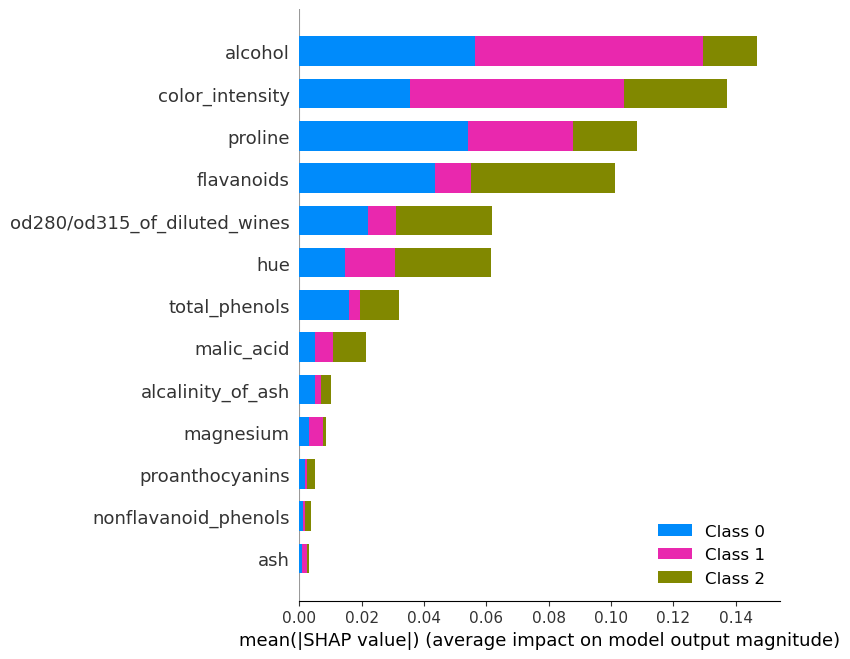

In [29]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [30]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Get indices of all instances of this class
    class_indices = np.where(y_dev == cls)[0]
    # Randomly select an indice from these indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 5, 1: 38, 2: 19}


In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


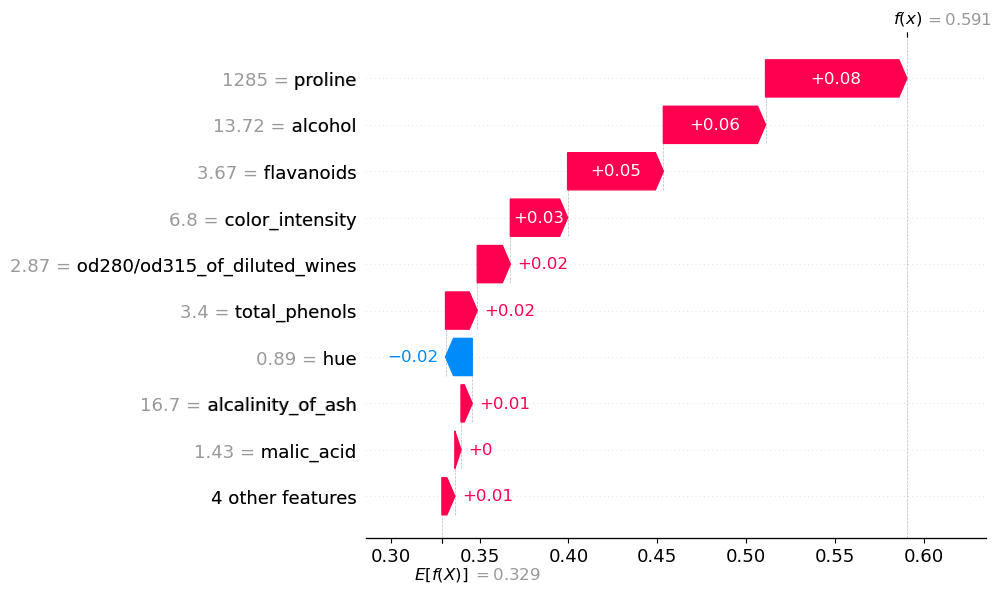

In [32]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

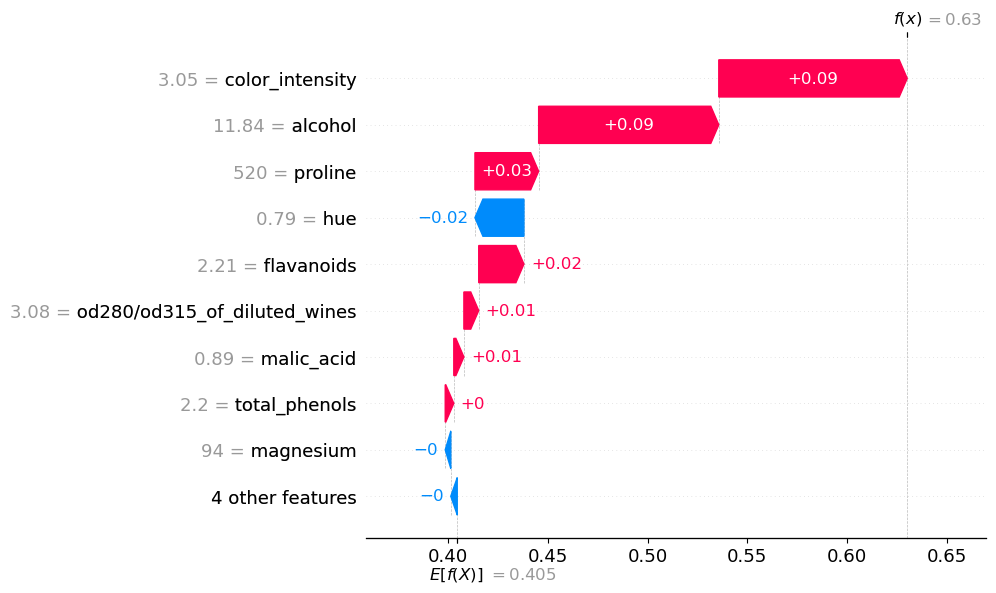

In [34]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

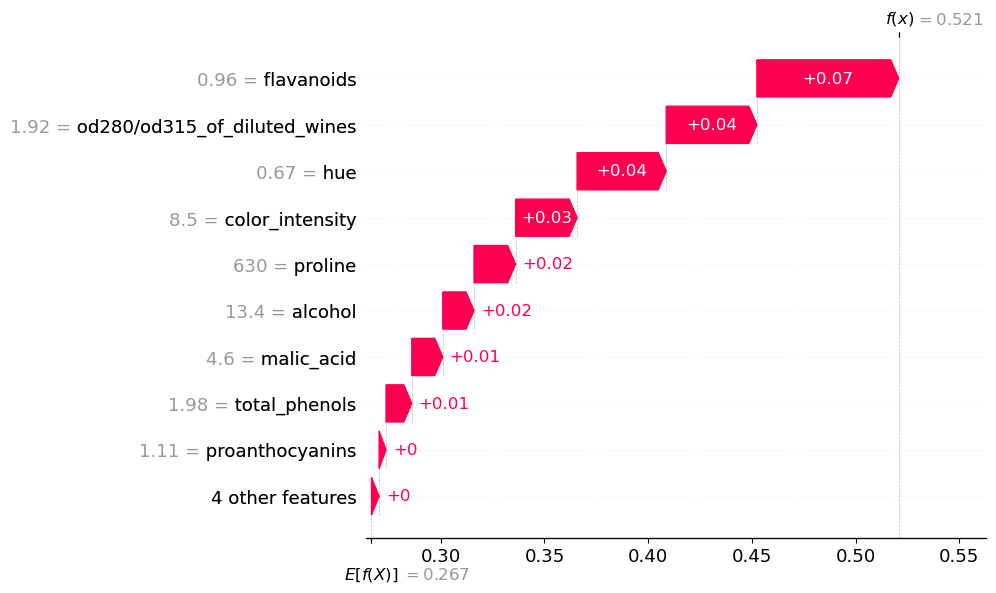

In [36]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))